# Tensile Data Results for FAIR 

This code analyzes a single experiment of tensile data for Aluminium 6061, and saves all data collected under PMDco ontology for later use.

Note: Refer to Tensile.py for the bacth processing of all the test in the "data" folder.

It will output 5 images and a text file that contains analyzis results for Sample geometry, Young's Modulus,
.2% YS, Modulus of Resilience, Strain Energy Density @ 0.2%, Toughness,
UTS, Final Strain(ef), and elastic recovery(er)

## Define working directories and results path

In [1]:
import subprocess
import os

# Get the directory of the current script or the parent directory
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.path.dirname(os.getcwd())
print(f'Current working directory = {script_dir}')

def install_requirements(requirements_file):
    try:
        subprocess.check_call(['pip', 'install', '-r', requirements_file])
        print("Successfully installed dependencies from", requirements_file)
    except subprocess.CalledProcessError as e:
        print("Error installing dependencies:", e)

if __name__ == "__main__":
    requirements_file = os.path.join(script_dir, "requirements.txt")
    install_requirements(requirements_file)

Current working directory = C:\Users\erwin\Downloads\FAIR_Ontology


In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from rdflib import Graph, URIRef, Literal, Namespace, RDF
import re

# Relative path to the data folder
data_folder = os.path.join(script_dir, 'data')
print(f'Path to data folder = {data_folder}')

# Create and Append a Text File with Data
def txtEdit(text, func):
    with open(os.path.join(img_path, material + '.txt'), func) as file:
        file.write(text)

def stress_from_load(l,w,t,mm_in=False):
    if mm_in == True:
        wi = w/25.4
        ti = t/25.4
        area = wi*ti
    else:
        area = w*t
    strs = l/area
    return(strs)

def strain_from_displacement(d,lngth):
    strn = d/lngth
    return(strn)

def true_from_eng(a,b):
    sigma_t = np.copy(a)
    epsilon_t = np.copy(b)
    ii=0
    for ii in range(len(a)):
        sigma_t[ii] = a[ii]*(1+b[ii])
        epsilon_t[ii] = np.log(1+b[ii])
    return(sigma_t,epsilon_t)

Path to data folder = C:\Users\erwin\Downloads\FAIR_Ontology\data


## Load Tensile Data from Excel Reports

- Extracts all file names from data folder and creates result folder for individual test
- Creates text file for analyzis
- Loads Load-Displacement data from excel file

In [3]:
# Access data files using relative paths
tensile_basename_list = sorted([os.path.basename(x) for x in glob.glob(data_folder + '/*.xlsx')])

# Create Results Folder
try: 
    os.mkdir(script_dir + 'results')
except(FileExistsError, IndexError, ValueError, ZeroDivisionError) as e:
    print(e)   
    
img_folder_path = os.path.join(script_dir, 'results')
print(f'Results folder path = {img_folder_path}')

for filename in tensile_basename_list[:-8]:
    print(filename)
    
fname = os.path.join(data_folder, filename)
material = filename.replace('.xlsx','')
print(material)
    
try: 
    os.mkdir(os.path.join(img_folder_path, material))
except(FileExistsError, IndexError, ValueError, ZeroDivisionError) as e:
    print(e)
    
img_path = os.path.join(img_folder_path, material)
print(f'Metadata Result File = {img_path}')
txtEdit(os.path.join(img_path, material)+'\n\n','w')

try:
    df = pd.read_excel(fname, sheet_name='Sheet2', header=None)
    print("Successfully read the Excel file.")
except Exception as e:
    print("Error occurred while reading the Excel file:", e)
    print('Data Name Convention Breached\n\n')
    txtEdit('Data Name Convention Breached\n\n','a')
    
    #continue

Results folder path = C:\Users\erwin\Downloads\FAIR_Ontology\results
1018 Steel.xlsx
1018 Steel2.xlsx
1018 Steel3.xlsx
1018 Steel5.xlsx
1018 Steel6.xlsx
1018 Steel7.xlsx
1018 Steel8.xlsx
1018 Steel9.xlsx
4130 Steel1.xlsx
4130 Steel2.xlsx
4130 Steel3.xlsx
6061 Aluminum.xlsx
6061 Aluminum1.xlsx
6061 Aluminum2.xlsx
6061 Aluminum2
Metadata Result File = C:\Users\erwin\Downloads\FAIR_Ontology\results\6061 Aluminum2
Successfully read the Excel file.


## Explore Sample Geometry

Explores the report sheet of the excel to extract the following
- Lenght
- Width
- Thickness 
- Units

It appends this info to the material's result txt file

In [4]:
#Find Column Index of mm
dfcol = df
col = dfcol
for i in range(len(col)):
    try:
        if any(dfcol.iloc[i].str.contains('mm')==True):
            breakpoint = i
            break
    #Uniformalize? the Data
    except(AttributeError):
        dfcol = dfcol.T
        dfcol.insert(0,'0',np.nan)
        dfcol = dfcol.T
        dfcol.fillna('empty',inplace=True)
        if any(dfcol.iloc[i].str.contains('mm')==True):
            breakpoint = i
            break
            
# print(dfcol.iloc[breakpoint])

# Save raw data to a DataFrame
raw_data_df = dfcol.copy() 

# Drop rows before the header row
raw_data_df = raw_data_df.iloc[breakpoint:]

# Drop the first row as it contains the headers
raw_data_df = raw_data_df.iloc[1:]

# Save processed stress-strain data to CSV files
raw_data_df.to_csv(os.path.join(img_path,'raw_load_disp_data.csv'), index=False)

print("Raw Data Stored to raw_data_df")
print(f"Raw Data Saved to = {os.path.join(img_path,'raw_load_disp_data.csv')}")


try:
    df2 = pd.read_excel(fname, sheet_name='Test Report')
except:
    print('Data Name Convention Breached\n\n')
    txtEdit('Data Name Convention Breached\n\n','a')
    #continue
    
#Find Length
a = np.where(df2['Default Test Run Report'].str.contains('Initial Marked Gage Length')==True)
a = int(a[0])
dflen = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dflen = dflen.T
s_length = dflen.iloc[1,0]
print('Length:'+str(s_length))
txtEdit('Length:'+str(s_length)+'\n','a')
    
#Find Width
a = np.array(np.where(df2['Default Test Run Report'].str.contains('Width')==True)).flatten()
a = int(a[0])
dfw = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dfw = dfw.T
width = dfw.iloc[1,0]
print('Width:'+str(width))
txtEdit('Width:'+str(width)+'\n','a')
    
#Find Thickness
a = np.array(np.where(df2['Default Test Run Report'].str.contains('Thickness')==True)).flatten()
a = int(a[0])
dft = pd.read_excel(fname, sheet_name='Test Report',skiprows=a,nrows=1)
dft = dft.T
thickness = dft.iloc[1,0]
print('Thickness:'+str(thickness))
txtEdit('Thickness:'+str(thickness)+'\n','a')
    
#Find Stress and Strain
try:
    dfdat = pd.read_excel(fname, sheet_name='Sheet2',skiprows=breakpoint)
    dfdat.dropna(subset=['mm'],inplace=True)
    completion = True
except:
    completion = False
 
    if completion == False:
        try:
            dfdat = pd.read_excel(fname, sheet_name='Sheet2',skiprows=breakpoint+1)
            dfdat.dropna(subset=['mm'],inplace=True)
        except:
            print('Data Layout Unsupported\n\n')
            txtEdit('Data Layout Unsupported\n\n','a')
            #continue
        
try:
    dfdat.dropna(subset=['N'],inplace=True)
    load = np.array(dfdat['N'])
    stress = stress_from_load(load,width,thickness)
    y_units = 'MPa'
    print('Units: MPa')
    txtEdit('Units: MPa'+'\n','a')
except:
    dfdat.dropna(subset=['lbf'],inplace=True)
    load = np.array(dfdat['lbf'])
    stress = stress_from_load(load,width,thickness,mm_in=True)
    y_units = 'psi'
    print('Units: psi')
    txtEdit('Units: psi'+'\n','a')
    
displacement = np.array(dfdat['mm'])
strain = strain_from_displacement(displacement,s_length)

Raw Data Stored to raw_data_df
Raw Data Saved to = C:\Users\erwin\Downloads\FAIR_Ontology\results\6061 Aluminum2\raw_load_disp_data.csv
Length:50
Width:13.53
Thickness:3.12
Units: MPa


## Generate Stress-Strain Graph 

- Cleans load-displacement data and converts it to stress-strain
- Plots and saves the result

Processed Engineering Data Stored to processed_stress_strain_df
Processed Engineering Saved to = C:\Users\erwin\Downloads\FAIR_Ontology\results\6061 Aluminum2\engineering_stress_strain_data.csv


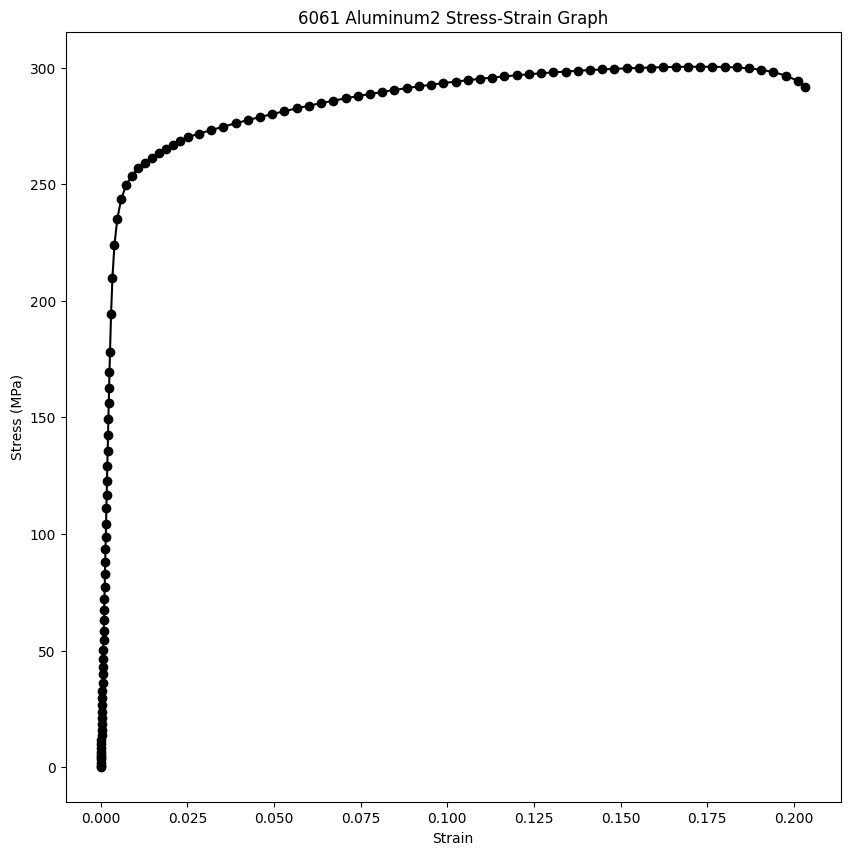

In [5]:
"""
Smooth Dataset
"""

#Set Moving Window
winSize = 25
    
smooth_x = np.array([])
smooth_y = np.array([])
length = len(stress)
j=0
while j < length - 1:
    #print("j:", j, "length:", length)  # Debugging print statement
    check = np.sign(stress[j])
    try:
        strain[j+1]
    except:
        if check < 0:
            stress = np.delete(stress, j)
            strain = np.delete(strain, j)
            break
        
    if check < 0:
        stress = np.delete(stress, j)
        strain = np.delete(strain, j)
        j = j - 1
    elif np.sign(strain[j+1] - strain[j]) < 0:
        stress = np.delete(stress, j)
        strain = np.delete(strain, j)
        j = j - 1
    else:
        pass
    length = len(stress)
    j = j + 1
 #   print(stress)
    
i = 0
while i < len(strain):
    datx = np.average(strain[i:i+winSize])
    daty = np.average(stress[i:i+winSize])
    datarrX = np.array([datx])
    datarrY = np.array([daty])
    smooth_x = np.append(smooth_x,datarrX)
    smooth_y = np.append(smooth_y,datarrY)
    i = i+winSize
    
# Create DataFrames for processed stress-strain data
processed_stress_strain_df = pd.DataFrame({'strain': smooth_x, 'stress': smooth_y})

# Save processed stress-strain data to CSV files
processed_stress_strain_df.to_csv(os.path.join(img_path,'engineering_stress_strain_data.csv'), index=False)

print("Processed Engineering Data Stored to processed_stress_strain_df")
print(f"Processed Engineering Saved to = {os.path.join(img_path,'engineering_stress_strain_data.csv')}")

#print(smooth_x,smooth_y)
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material) + ' Stress-Strain Graph'
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
fig.savefig(os.path.join(img_path, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot True Stress-Strain Graph

- Calculates true stress and strain from and plots it alongside with the engineering stress-strain
- Saves the plot 

Processed True Data Stored to true_stress_strain_df
Processed True Saved to = C:\Users\erwin\Downloads\FAIR_Ontology\results\6061 Aluminum2\ture_stress_strain_data.csv


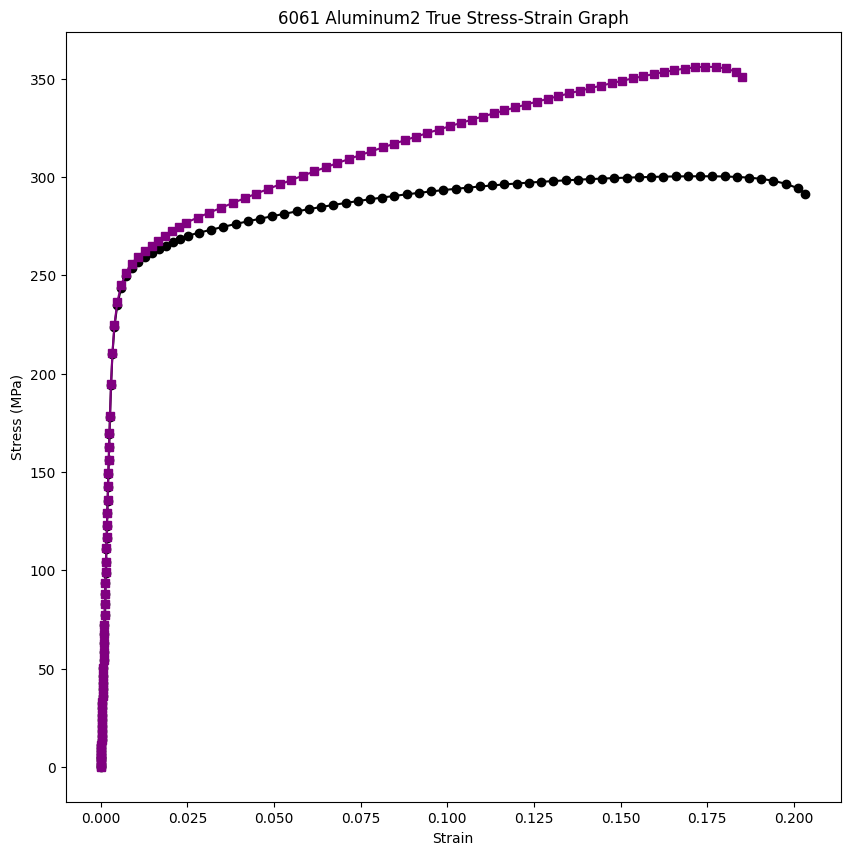

In [6]:
"""
True Stress/Strain
"""
#Call function
true_smooth_y,true_smooth_x = true_from_eng(smooth_y,smooth_x)

# Create DataFrames for processed stress-strain data
true_stress_strain_df = pd.DataFrame({'strain': true_smooth_x, 'stress': true_smooth_y})

# Save processed stress-strain data to CSV files
true_stress_strain_df.to_csv(os.path.join(img_path,'ture_stress_strain_data.csv'), index=False)

print("Processed True Data Stored to true_stress_strain_df")
print(f"Processed True Saved to = {os.path.join(img_path,'ture_stress_strain_data.csv')}")

    
#Plot True Stress/Strain
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material)+' True Stress-Strain Graph'
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
plt.plot(true_smooth_x,true_smooth_y,marker='s',color='purple')
fig.savefig(os.path.join(img_path, figname) + '.png', dpi=300, bbox_inches='tight')
plt.show()
smooth_y = true_smooth_y
smooth_x = true_smooth_x
    

## Calculate Young's Modulus

- Takes the Young's Modulus from a section of the linear component
- Appends result to txt file

In [7]:
"""
Young's Modulus
"""
#Find E
start=10
i=start+1
Ei = np.array([])
Eact = np.array([])
error = 0.1
pings = 0
k=1
while i < len(smooth_x):
    Epoint = (smooth_y[i]-smooth_y[i-1])/(smooth_x[i]-smooth_x[i-1])
    Earr = np.array([Epoint])
    Ei = np.append(Ei,Earr)
    Eavg = np.average(Ei)
    if i >= start+2:
        if Eavg/Ei[k-1] > (3+error) or Eavg/Ei[k-1] < (1-error):
   #       print(Ei[k-1])
            pings = pings+1
        else:
            Eact = np.append(Eact,Ei[k-1])
            pings = 0
            breakpoint = i
    else:
        pass
    
    if pings >= 5:
        Ei = np.delete(Ei,k-1)
        break
    else:
        pass
    i = i + 1
    k = k + 1
  #  print(Eact)

E = np.average(Eact)
print("Young's Modulus = {}".format(int(np.round(E,0)))+' '+ y_units)
txtEdit("Young's Modulus = {}".format(int(np.round(E,0)))+' '+y_units+'\n','a')
  #  print(breakpoint)

Young's Modulus = 66047 MPa


## Calculate Proportional Limit 

- Calculates proportional limit and adds it to the engineering stress-strain graph
- Plots and save the figure
- Appends the result to txt file

Proportional Limit = 203.81 MPa


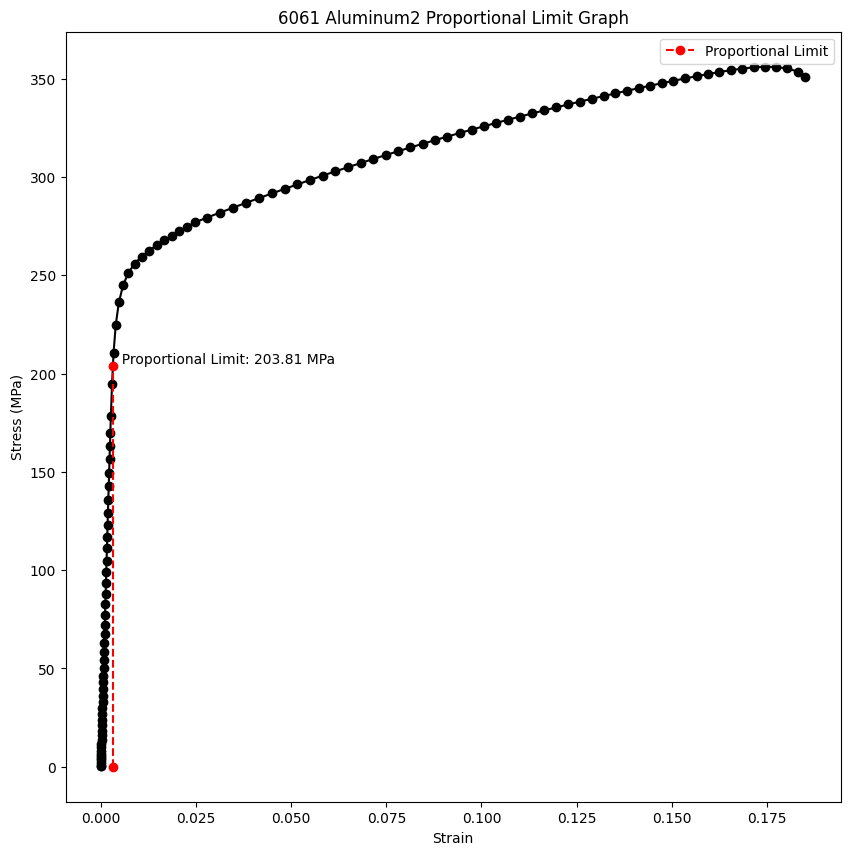

In [8]:
"""
Proportional Limit
"""
#Find Proportional Limit
length = winSize * breakpoint
winMin = length - winSize
winMax = length + winSize
small_x = np.array([])
small_y = np.array([])
sEi = np.array([])
    
winSizeSmall = 1
    
i = winMin
smallError = 0.1
k = 1
while i < winMax:
    pl = i
    sdatx = np.average(strain[i:i+winSizeSmall])
    sdaty = np.average(stress[i:i+winSizeSmall])
    sdatarrX = np.array([sdatx])
    sdatarrY = np.array([sdaty])
    small_x = np.append(small_x,sdatarrX)
    small_y = np.append(small_y,sdatarrY)
    if len(small_x) >= 2:
        sEpoint = (small_y[k-1]-small_y[k-2])/(small_x[k-1]-small_x[k-2])
        sEarr = np.array([sEpoint])
        sEi = np.append(sEi,sEarr)
        if len(sEi) >= 2:
            if sEi[k-3]/sEi[k-2] > (1+smallError) or sEi[k-3]/sEi[k-2] < (1-smallError):
                break
            else:
                pass
        else:
            pass
    else:
        pass
    k = k+1
    i = i+winSizeSmall
    
plx = np.linspace(strain[pl],strain[pl],2)
ply = np.linspace(0,stress[pl],2)

print("Proportional Limit = {:.2f} {}".format(ply[-1], y_units))
txtEdit("Proportional Limit = {:.2f} {}\n".format(ply[-1], y_units), 'a')


# Plot proportional limit
fig, ax = plt.subplots(figsize=(10, 10))
figname = f"{material} Proportional Limit Graph"
plt.title(figname)
plt.ylabel('Stress (' + y_units + ')')
plt.xlabel("Strain")
plt.plot(smooth_x, smooth_y, marker='o', color='black')
plt.plot(plx, ply, marker='o', color='red', linestyle='dashed', label='Proportional Limit')
plt.legend()
plt.text(plx[-1], ply[-1], f'  Proportional Limit: {ply[-1]:.2f} {y_units}', 
         verticalalignment='bottom', horizontalalignment='left')

# Save and display the plot
fig.savefig(os.path.join(img_path, figname)+ '.png', dpi=300, bbox_inches='tight')
plt.show()



## Calculate the 2% Offset

- Calculates 2% Offset
- Appends result to txt file

In [9]:
"""
0.2% Offset
"""
#Find 0.2% Offset
stress_offset = np.copy(smooth_y)
strain_offset = np.copy(smooth_x)
for i in range(len(stress_offset)):
    strain_offset[i] = (stress_offset[i]/E) + 0.002
indx = int(np.argwhere(np.diff(np.sign(strain_offset-smooth_x))).flatten())
  #  print(indx)
mult = 2
length = winSize * indx
  #  print(length)
winMin = length - winSize*mult
winMax = length + winSize*mult
small_strain = np.array([])
small_stress = np.array([])
i = winMin
while i < winMax:
    offset_datx = np.average(strain[i:i+winSizeSmall])
    offset_daty = np.average(stress[i:i+winSizeSmall])
    offset_datarrX = np.array([offset_datx])
    offset_datarrY = np.array([offset_daty])
    small_strain = np.append(small_strain,offset_datarrX)
    small_stress = np.append(small_stress,offset_datarrY)
    i = i+winSizeSmall
    
stress_offset_fine = np.copy(small_stress)
strain_offset_fine = np.copy(small_strain)

for i in range(len(stress_offset_fine)):
    strain_offset_fine[i] = (stress_offset_fine[i]/E) + 0.002
    
window=winMax-winMin

###USE ONLY FOR LARGE DATA SETS
fine_indx = int(np.argwhere(np.diff(np.sign(strain_offset_fine-small_strain))).flatten())
  #  print(fine_indx)
new_indx = winMin+((fine_indx)*winSizeSmall)
  # print(new_indx)
  
print('0.2% Yield Strength = {}'.format(np.round(stress_offset_fine[fine_indx],3)) + y_units)
txtEdit('0.2% Yield Strength = {}'.format(np.round(stress_offset_fine[fine_indx],3))+y_units+'\n','a')
    
    

0.2% Yield Strength = 242.538MPa


## Calculate Modulus of Resilience

- Calculates Modulus of Resilience at Proportional Limit
- Calculates Strain Energy Density at 0.2% Offset
- Plots the regions under stress-strain graph
- Appends results to txt file

Modulus of Resilience at Proportional Limit = 0.314 MPa
Strain Energy Density at 0.2% Offset = 0.445 MPa


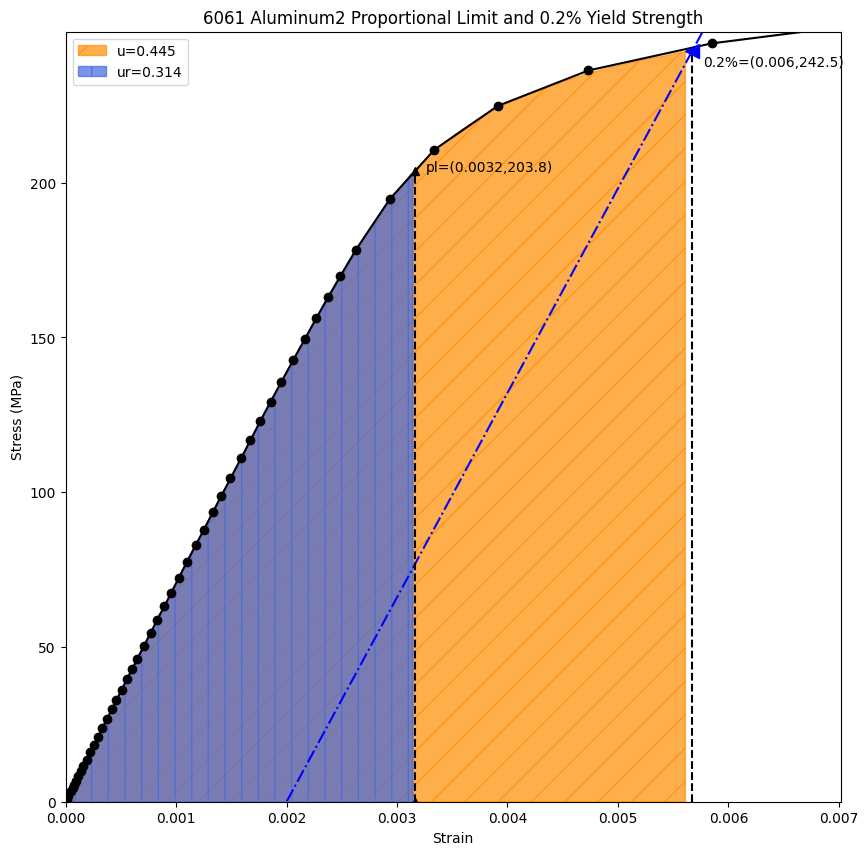

In [10]:
"""
Modulus of Resilience
"""
ur = (1/2)*(stress[pl]**2/E)
print('Modulus of Resilience at Proportional Limit = {}'.format(np.round(ur,3))+" "+y_units)
txtEdit('Modulus of Resilience at Proportional Limit = {}'.format(np.round(ur,3))+" "+y_units+'\n','a')
ur_offset = (1/2)*(stress_offset_fine[fine_indx]**2/E)
print('Strain Energy Density at 0.2% Offset = {}'.format(np.round(ur_offset,3))+" "+ y_units)
txtEdit('Strain Energy Density at 0.2% Offset = {}'.format(np.round(ur_offset,3))+" "+y_units+'\n','a')
    
#Plot Moduli of Resilience
ofst2x = np.linspace(strain_offset_fine[fine_indx],strain_offset_fine[fine_indx],2)
ofst2y = np.linspace(0,stress_offset_fine[fine_indx],2)
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material)+' Proportional Limit and 0.2% Yield Strength'
plt.title(figname)
plt.xlim(0,strain[new_indx+winSize])
plt.ylim(0,stress[new_indx+winSize])
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(strain_offset,stress_offset,color='b',linestyle='-.')
plt.plot(smooth_x,smooth_y,marker='o',color='black')
plt.plot(plx,ply,marker='^',color='black',linestyle='--')
plt.plot(ofst2x,ofst2y,color='black',linestyle='--')
plt.plot(strain_offset_fine[fine_indx],stress_offset_fine[fine_indx],marker='<',color='b',markersize=10)
plt.annotate('pl=({},{})'.format(np.round(strain[pl],4),np.round(stress[pl],1)),
                (strain[pl],stress[pl]),(strain[pl]+0.0001,stress[pl]))
plt.annotate('0.2%=({},{})'.format(np.round(strain_offset_fine[fine_indx],3),
                                       np.round(stress_offset_fine[fine_indx],1)),
                 (strain_offset_fine[fine_indx],stress_offset_fine[fine_indx]),
                 (strain_offset_fine[fine_indx]+0.0001,stress_offset_fine[fine_indx]-5))
    
plt.fill_between(strain[0:new_indx],stress[0:new_indx],color='darkorange',alpha=0.7,hatch='/',
                     label='u={}'.format(np.round(ur_offset,3)))
plt.fill_between(strain[0:pl],stress[0:pl],color='royalblue',alpha=0.7,hatch='|',
                    label='ur={}'.format(np.round(ur,3)))
plt.legend()
fig.savefig(os.path.join(img_path, figname)+ '.png', dpi=300, bbox_inches='tight')
plt.show()
    
    

## Calculate Modulus of Toughness
- Calculates Modulus of Toughness
- Appends result to txt file

In [11]:
"""
Modulus of Toughness
"""
#Create Rectangles
area = 0
for i in range(1,len(smooth_x)):
    w = smooth_x[i]-smooth_x[i-1]
    h = (smooth_y[i]+smooth_y[i-1])/2
    rec = w*h
    area=area+rec
print('Modulus of Toughness = {}'.format(np.round(area,3))+" "+y_units)
txtEdit('Modulus of Toughness = {}'.format(np.round(area,3))+" "+y_units+'\n','a')
    
    

Modulus of Toughness = 58.035 MPa


## Caculate UTS and Strain at Failure

- Caculates UTS 
- Caculates Strain at Failure
- Caculate elastic recovery
- Plot UTS and Strain at Failure
- Saves figure 
- Appends result to txt file

UTS=356.1 MPa
ef=0.1851
er=0.1797


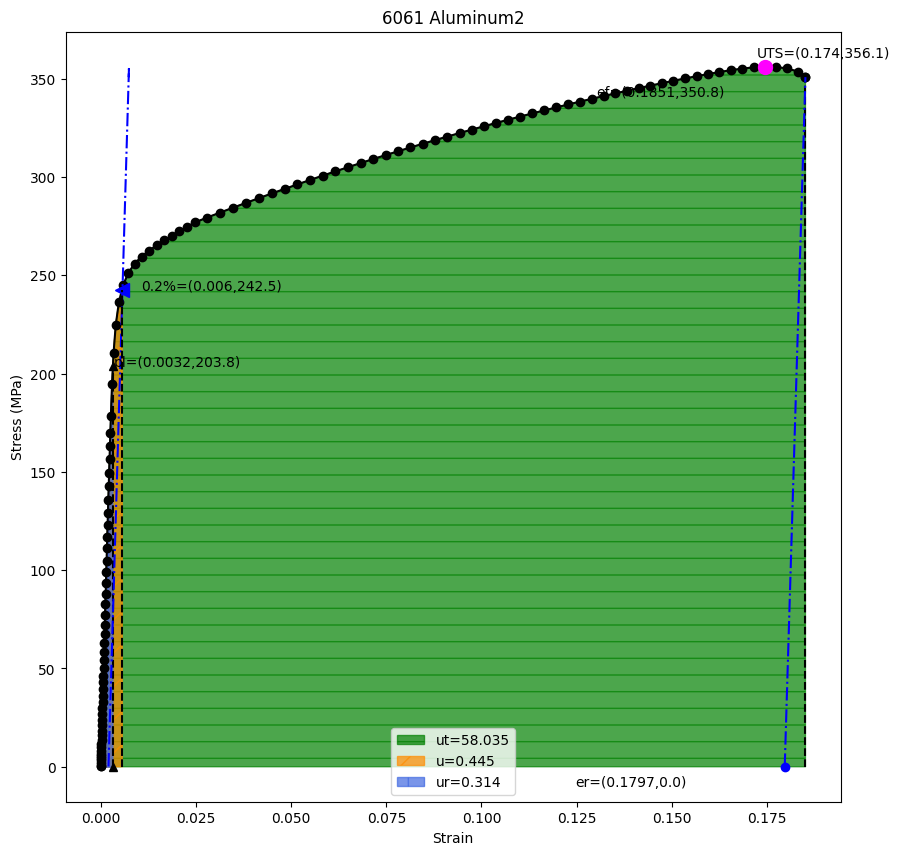

In [12]:
"""
UTS and Strain at Failure
"""
#Ultimate Tensile Strength
UTS = np.argmax(smooth_y)
print('UTS={}'.format(np.round(smooth_y[UTS],1))+" "+y_units)
txtEdit('UTS={}'.format(np.round(smooth_y[UTS],1))+" "+y_units+'\n','a')
    
#Strain at Failure
ef = np.argmax(smooth_x)
print('ef={}'.format(np.round(smooth_x[ef],4)))
txtEdit('ef={}'.format(np.round(smooth_x[ef],4))+'\n','a')
xef=np.linspace(smooth_x[ef],smooth_x[ef],2)
yef=np.linspace(0,smooth_y[ef],2)
    
#Find Elastic Recovery
tantheta = stress[pl]/strain[pl]
theta = np.arctan(tantheta)
elastic_ef = smooth_x[ef]-(smooth_y[ef]/np.tan(theta))
print('er={}'.format(np.round(elastic_ef,4)))
txtEdit('er={}'.format(np.round(elastic_ef,4))+'\n','a')
xEAF = np.linspace(elastic_ef,smooth_x[ef],2)
yEAF = np.linspace(0,smooth_y[ef],2)
    
#Plot UTS and Strain at Failure
fig,ax = plt.subplots(figsize=(10,10))
figname = str(material)
plt.title(figname)
plt.ylabel('Stress ('+y_units+')')
plt.xlabel("Strain")
plt.plot(smooth_x,smooth_y,marker='o',color='black')
    
#Proportional Limit
plt.plot(plx,ply,marker='^',color='black',linestyle='--')
plt.annotate('pl=({},{})'.format(np.round(strain[pl],4),np.round(stress[pl],1)),
                 (strain[pl],stress[pl]),(strain[pl]+0.0001,stress[pl]))
    
#0.2% Offset
plt.plot(strain_offset,stress_offset,color='b',linestyle='-.')
plt.annotate('0.2%=({},{})'.format(np.round(strain_offset_fine[fine_indx],3),
                                       np.round(stress_offset_fine[fine_indx],1)),
                 (strain_offset_fine[fine_indx],stress_offset_fine[fine_indx]),
                 (strain_offset_fine[fine_indx]+0.005,stress_offset_fine[fine_indx]))
plt.plot(strain[new_indx],stress[new_indx],marker='<',color='b',markersize=10)
    
#Resilience/Elastic Strain Energy/Toughness
plt.plot(ofst2x,ofst2y,color='black',linestyle='--')
plt.fill_between(smooth_x,smooth_y,color='green',alpha=0.7,hatch='-',
                    label='ut={}'.format(np.round(area,3)))
plt.fill_between(strain[0:new_indx],stress[0:new_indx],color='darkorange',alpha=0.7,hatch='/',
                     label='u={}'.format(np.round(ur_offset,3)))
plt.fill_between(strain[0:pl],stress[0:pl],color='royalblue',alpha=0.7,hatch='|',
                    label='ur={}'.format(np.round(ur,3)))
    
#UTS and Strain at Failure
plt.plot(smooth_x[UTS],smooth_y[UTS],marker='o',markersize=10,color='magenta')
plt.annotate('UTS=({},{})'.format(np.round(smooth_x[UTS],3),np.round(smooth_y[UTS],1)),
                 (smooth_x[UTS],smooth_y[UTS]),(smooth_x[UTS]-0.002,smooth_y[UTS]+5))
plt.plot(xef,yef,color='black',linestyle='--')
plt.plot(smooth_x[ef],smooth_y[ef],marker='o',color='black')
plt.annotate('ef=({},{})'.format(np.round(smooth_x[ef],4),np.round(smooth_y[ef],1)),
                 (smooth_x[ef],smooth_y[ef]),(smooth_x[ef]-0.055,smooth_y[ef]-10))
    
plt.plot(xEAF,yEAF,color='blue',linestyle='-.')
plt.plot(xEAF[0],yEAF[0],marker='o',color='b')
plt.annotate('er=({},{})'.format(np.round(xEAF[0],4),np.round(yEAF[0],1)),
                 (xEAF[0],yEAF[0]),(xEAF[0]-0.055,yEAF[0]-10))
    
    
plt.legend()
fig.savefig(os.path.join(img_path, figname)+ '.png', dpi=300, bbox_inches='tight')
plt.show()
print('\n\n')


# FAIR Graph Making and Data Capture

Here we will be using [PMDco](https://materialdigital.github.io/core-ontology/index-en.html#) Ontology that uses Triplets to build all the data acquired from excel report and the processed results obtained. 

In the provided code snippet that creates the RDF file, triplets are constructed based on the Subject, Predicate, and Object. Here's how each component contributes to organizing and structuring the data:

**Subject:** The Subject represents the entity or variable for which information is being described or recorded. In this context, the Subject often corresponds to specific entities in the domain of materials testing, such as materials, test results, or data points. For example, **material_rdf** serves as the Subject when describing test results associated with a particular material.</br>

**Predicate:** The Predicate defines the relationship or property that connects the Subject to the Object in the RDF graph. It signifies how the Subject and Object are related to each other. Predicates often represent attributes, properties, or relationships between entities. For instance, predicates like **test**, **length_rdf**,**width_rdf**, and **yield_strength** specify properties such as the type of test performed, the length of a specimen, its width, and its yield strength, respectively.</br>

**Object:** The Object represents the value or data associated with the Subject-Predicate relationship. It can be a literal value (such as strings, numbers, or dates) or a resource (such as another URI). The Object provides the specific information or data being asserted in the RDF graph. For example, **Literal(s_length)** represents the literal value of the length of a specimen, while **URIRef(PMDco.Material)** denotes the URI reference for the Material class in the PMDco ontology.</br>


By structuring the RDF triplets in this way, the code effectively captures and represents information about materials testing in a structured and machine-readable format. Additionally, separating raw data and processed data into distinct URIs (raw_data_uri and processed_data_uri) enhances clarity and organization, facilitating easier interpretation and analysis of the data.</br>


**Clarity and Organization:** By saving raw data and processed data under different URIs (raw_data_uri and processed_data_uri), it's easier to distinguish between the two types of data. This separation enhances the clarity of the RDF graph structure and makes it easier for both humans and machines to understand the data model. </br>

**Different Data Processing Stages:** Raw data represents the initial data captured from experiments or measurements, while processed data undergoes some form of analysis or transformation. By storing them separately, it reflects their distinct stages in the data processing pipeline. </br>

**Granularity and Detail:** Raw data typically contains a large volume of data points, whereas processed data may have fewer points but with additional derived information (such as stress-strain curves). Separating them allows for a clear distinction in granularity and detail. </br>

**Flexibility and Modularity:** Storing data under specific URIs provides flexibility for future extensions or modifications to the data model. For example, if you later decide to include additional processing steps or intermediate results, you can easily do so without impacting the existing structure.

In [13]:
# Create a new RDF graph
g = Graph()

# Define namespaces
PMDco = Namespace("https://w3id.org/pmd/co/")
PMDco_material = PMDco.Material
PMDco_PrimaryData = PMDco.PrimaryData
PMDco_hasProcessedData = PMDco.hasProcessedData
PMDco_hasProperty = PMDco.hasProperty

# Define URIs for raw and processed data based on the material variable
raw_data_uri = URIRef(f"https://materialtest.org/{material.replace(' ', '_')}/primary_data/")
processed_data_uri = URIRef(f"https://materialtest.org/{material.replace(' ', '_')}/secondary_data/")

# Define resources
material_rdf = URIRef(PMDco.Material) #_rdf added to differientiate
test = URIRef(PMDco.TensileTest)
result = URIRef(PMDco.TestResult)
length_rdf = URIRef(PMDco.Length)
width_rdf = URIRef(PMDco.Width)
thickness_rdf = URIRef(PMDco.Thickness)
units = URIRef(PMDco.Units)
youngs_modulus = URIRef(PMDco.YoungsModulus)
yield_strength = URIRef(PMDco.YieldStrength)
proportional_limit = URIRef(PMDco.ProportionalLimit)
stress_strain_data = URIRef(PMDco.StressStrainDataPoint)
true_stress_true_strain_data = URIRef(PMDco.TrueStressTrueStrainDataPoint)
modulus_resilience = URIRef(PMDco.ModulusOfResilience)
strain_energy_density = URIRef(PMDco.StrainEnergyDensity)
modulus_toughness = URIRef(PMDco.ModulusOfToughness)
ultimate_tensile_strength = URIRef(PMDco.UltimateTensileStrength)
engineering_strain = URIRef(PMDco.EngineeringStrain)
engineering_stress = URIRef(PMDco.EngineeringStress)

# Add the material name to the RDF file under material
g.add((material_rdf, RDF.type, PMDco.Material))
g.add((material_rdf, PMDco.hasName, Literal(material)))

# Add triples for test results
g.add((material_rdf, test, result))
g.add((result, length_rdf, Literal(s_length)))
g.add((result, width_rdf, Literal(width)))
g.add((result, thickness_rdf, Literal(thickness)))
g.add((result, units, Literal(y_units)))
g.add((result, youngs_modulus, Literal(E)))
g.add((result, yield_strength, Literal(np.round(stress_offset_fine[fine_indx],3))))
g.add((result, proportional_limit, Literal(ply[-1])))
g.add((result, modulus_resilience, Literal(np.round(ur,3))))
g.add((result, strain_energy_density, Literal(np.round(ur_offset,3))))
g.add((result, modulus_toughness, Literal(np.round(area,3))))
g.add((result, ultimate_tensile_strength, Literal(UTS)))
g.add((result, engineering_strain, Literal(np.round(smooth_x[ef],4))))
g.add((result, engineering_stress, Literal(np.round(smooth_x[ef],4))))

# Add triples for raw data
for index, row in raw_data_df.iterrows():
    displacement = row[0]
    load = row[1]
    # Create a unique URI for the raw data point
    data_point = URIRef(raw_data_uri + f"/LoadDisplacementPoint/{index}")
    # Link the raw data point to its displacement and load values
    g.add((data_point, PMDco.hasDisplacement, Literal(displacement)))
    g.add((data_point, PMDco.hasLoad, Literal(load)))

# Add triples for stress-strain data
for index, row in processed_stress_strain_df.iterrows():
    stress = row['stress']
    strain = row['strain']
    data_point = URIRef(processed_data_uri + f'/StressStrainDataPoint/{index}')
    g.add((data_point, PMDco.hasStress, Literal(stress)))
    g.add((data_point, PMDco.hasStrain, Literal(strain)))

# Add triples for true-stress-true-strain data
for index, row in true_stress_strain_df.iterrows():
    true_stress = row['stress']
    true_strain = row['strain']
    data_point = URIRef(processed_data_uri + f'/TrueStressTrueStrainDataPoint/{index}')
    g.add((data_point, PMDco.hasTrueStress, Literal(true_stress)))
    g.add((data_point, PMDco.hasTrueStrain, Literal(true_strain)))

# Serialize the graph to RDF/XML format
graph_fname = f"{material.replace(' ', '_')}_graph.rdf"
g.serialize(destination=os.path.join(img_path, graph_fname), format="xml")


## Reading Defined Graph from saved File

In this section we will retrieve the jsut generated rdf file to understand, and ensure all data is saved.

In this code snippet, we load the RDF Graph from and iterate through its contents. It serves as an example to understand subject, predicate and object relationships 

In [22]:
# Load the RDF graph
g = Graph()
graph_fname = os.path.join(img_path, f"{material.replace(' ', '_')}_graph.rdf")
g.parse(graph_fname, format="xml")

# Define your namespaces
PMDco = Namespace("https://w3id.org/pmd/co/")
RDF = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")

# Example: Count the number of triples in the graph
num_triples = len(g)
print("Number of triples in the graph:", num_triples)

# Example: Iterate over triples and extract information
for s, p, o in g:
    # Check if the triple belongs to a specific namespace
    if p.startswith(PMDco):
        print("Subject:", s)
        print("Predicate:", p)
        print("Object:", o)
        print()

# Example: Query the graph using SPARQL
query = """
    SELECT ?subject ?property ?value
    WHERE {
        ?subject ?property ?value .
    }
"""
try:
    results = g.query(query, initNs={"pmdco": PMDco})
    for i, row in enumerate(results):
        if i % 100 == 0:
            print(row)
except Exception as e:
    print("An error occurred during the query execution:", e)


Number of triples in the graph: 7258
Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/1423
Predicate: https://w3id.org/pmd/co/hasLoad
Object: 4638.66552734375

Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/905
Predicate: https://w3id.org/pmd/co/hasDisplacement
Object: 0.0301377875334487

Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/2189
Predicate: https://w3id.org/pmd/co/hasLoad
Object: 11553.6865234375

Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/515
Predicate: https://w3id.org/pmd/co/hasLoad
Object: 616.456726074219

Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/1976
Predicate: https://w3id.org/pmd/co/hasLoad
Object: 10925.7490234375

Subject: https://materialtest.org/6061_Aluminum2/primary_data//LoadDisplacementPoint/1324
Predicate: https://w3id.org/pmd/co/hasLoad
Object: 3958.86889648438

S

## Extracting Data from Graph 

### Extract Saved Datapoints for figures

In this section, we will iterate for saved data under Raw, Processed Engineering and Processed True data and save them under respective dataframes for later use

In [23]:
# Initialize lists to store extracted data
raw_data = []
processed_stress_strain_data = []
true_stress_strain_data = []

# Iterate over triples and extract information
for s, p, o in g:
    # Check if the triple belongs to raw data
    if p == PMDco.hasLoad:
        # Extract load and displacement data
        load = float(o)
        displacement = float(g.value(subject=s, predicate=PMDco.hasDisplacement))
        raw_data.append({'Displacement': displacement, 'Load': load})

    # Check if the triple belongs to stress-strain data
    elif p == PMDco.hasStress:
        # Extract stress and strain data
        stress = float(o)
        strain = float(g.value(subject=s, predicate=PMDco.hasStrain))
        processed_stress_strain_data.append({'Stress': stress, 'Strain': strain})

    # Check if the triple belongs to true-stress-true-strain data
    elif p == PMDco.hasTrueStress:
        # Extract true stress and true strain data
        true_stress = float(o)
        true_strain = float(g.value(subject=s, predicate=PMDco.hasTrueStrain))
        true_stress_strain_data.append({'True Stress': true_stress, 'True Strain': true_strain})

# Create DataFrames from the extracted data
ret_raw_data_df = pd.DataFrame(raw_data)
ret_processed_stress_strain_df = pd.DataFrame(processed_stress_strain_data)
ret_true_stress_strain_df = pd.DataFrame(true_stress_strain_data)

# Print or process the extracted DataFrames as needed
print("Raw Data DataFrame:")
print(ret_raw_data_df)
print("\n Stress-Strain DataFrame:")
print(ret_processed_stress_strain_df)
print("\nTrue Stress-True Strain DataFrame:")
print(ret_true_stress_strain_df)





Raw Data DataFrame:
      Displacement          Load
0         0.079174   4638.665527
1         1.647719  11553.686523
2         0.010025    616.456726
3         0.616262  10925.749023
4         0.067085   3958.868896
...            ...           ...
3394      0.047319   2818.077881
3395      0.997203  11229.880859
3396      0.640592  10952.175781
3397      0.007257    420.632172
3398      8.667937  12679.975586

[3399 rows x 2 columns]

 Stress-Strain DataFrame:
         Stress    Strain
0    177.909934  0.002632
1     67.426964  0.000956
2    291.203038  0.088267
3    194.219416  0.002941
4     39.738760  0.000557
..          ...       ...
106  295.722855  0.112961
107  291.513828  0.203344
108  287.775008  0.074157
109   54.402096  0.000769
110  298.314602  0.134128

[111 rows x 2 columns]

True Stress-True Strain DataFrame:
     True Stress  True Strain
0       6.543108     0.000093
1     224.789067     0.003911
2     325.801200     0.100665
3     286.847701     0.038144
4     332.

### Extract Results from Test

In this section we will extract the result data from the different calculated properties and save them under a dictionary

In [24]:
test_results = {}

# Iterate over triples and extract information
for s, p, o in g:
    
    # Check if triple corresponds to material
    if p == PMDco.hasName:
        # Extract relevant information
        test_results['material'] = o.toPython()
        
for s, p, o in g:
        
    # Check if the triple corresponds to test results
    if o == PMDco.TestResult:
        # Extract relevant information
        test_results['length'] = g.value(o, length_rdf).toPython()
        test_results['width'] = g.value(o, width_rdf).toPython()
        test_results['thickness'] = g.value(o, thickness_rdf).toPython()
        test_results['units'] = g.value(o, units).toPython()
        test_results['youngs_modulus'] = g.value(o, youngs_modulus).toPython()
        test_results['yield_strength'] = g.value(o, yield_strength).toPython()
        test_results['proportional_limit'] = g.value(o, proportional_limit).toPython()
        test_results['modulus_resilience'] = g.value(o, modulus_resilience).toPython()
        test_results['strain_energy_density'] = g.value(o, strain_energy_density).toPython()
        test_results['modulus_toughness'] = g.value(o, modulus_toughness).toPython()
        test_results['ultimate_tensile_strength'] = g.value(o, ultimate_tensile_strength).toPython()
        test_results['engineering_strain'] = g.value(o, engineering_strain).toPython()
        test_results['engineering_stress'] = g.value(o, engineering_stress).toPython()

# Print or process the extracted test results as needed
print("Test Results:")
print(test_results)



Test Results:
{'material': '6061 Aluminum2', 'length': 50, 'width': 13.53, 'thickness': 3.12, 'units': 'MPa', 'youngs_modulus': 66046.59786341149, 'yield_strength': 242.538, 'proportional_limit': 203.8074065215357, 'modulus_resilience': 0.314, 'strain_energy_density': 0.445, 'modulus_toughness': 58.035, 'ultimate_tensile_strength': '106', 'engineering_strain': 0.1851, 'engineering_stress': 0.1851}


Note: This are some methods to extract data from RDF files, and with such we ensure all dictionaries are equal, now we can compare multiple test using this methods. 